# 🎦**AlloCiné Data Analysis**📊

We had web scraped the [movies](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Movies_From_AlloCine.ipynb), [series](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Series_From_AlloCine.ipynb), and [ratings](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Ratings_From_AlloCine.ipynb) data from the [AlloCiné](https://www.allocine.fr/) website.

**Data description :**

This is a reminder of the features of the data we had scraped from the AlloCiné website.
Features|Movies|Series|Ratings
-------|---------|---------|---
`id`|X|X|-
`title`|X|X|-
`status`|-|X|-
`release_date`|X|X|-
`duration`|X|X|-
`nb_seasons`|-|X|-
`nb_episodes`|-|X|-
`genres`|X|X|-
`directors`|X|X|-
`actors`|X|X|-
`nationality`|X|X|-
`press_rating`|X|X|X
`nb_press_rating`|X|X|-
`spect_rating`|X|X|X
`nb_spect_rating`|X|X|-
`summary`|X|X|-
`poster_link`|X|X|-
`user_id`|-|-|X
`(user/press)_name`|-|-|X
`(movie/series)_id`|-|-|X
`date`|-|-|X

In this notebook, we will first look at the raw data statistics of all dataframes before proceeding to a oriented data cleaning. After this, 4 new tables will be created: the `genres` and `nationality` dataframes for both movies and series. Then, we will add and update some features to improve the data format and coherence. Finally, we will save all the cleaned dataframes in CSV files.

For our final study, we will us the data scraped from the first **600 pages** of the movies and series pages of the [AlloCiné](https://www.allocine.fr/) website. The data is dated from **May 6th, 2022** to **May 14th, 2022**. 

If you are interested in it, the data from all the movies, series and ratings scraping is available here:
- Raw data:
    - [movies](https://storage.cloud.google.com/bucket-bastien/Saved%20Data/allocine_movies_600p.csv).
    - [series](https://storage.cloud.google.com/bucket-bastien/Saved%20Data/allocine_series_600p.csv).
    - [press_ratings_movies](https://storage.cloud.google.com/bucket-bastien/Saved%20Data/press_ratings_movies_600p.csv).
    - [press_ratings_series](https://storage.cloud.google.com/bucket-bastien/Saved%20Data/press_ratings_series_600p.csv).
    - [user_ratings_movies](https://storage.cloud.google.com/bucket-bastien/Saved%20Data/user_ratings_movies_600p.csv).
    - [user_ratings_series](https://storage.cloud.google.com/bucket-bastien/Saved%20Data/user_ratings_series_600p.csv).

- Cleaned data:
    - [movies](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/movies.csv).
    - [series](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/series.csv).
    - [press_movies](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/press_movies.csv).
    - [press_series](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/press_series.csv).
    - [user_movies](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/user_movies.csv).
    - [user_series](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/user_series.csv).

- Additional data:
    - [movies_genres](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/m_genres.csv).
    - [series_genres](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/s_genres.csv).
    - [movies_nationality](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/m_nationality.csv).
    - [series_nationality](https://storage.cloud.google.com/bucket-bastien/Cleaned%20Data/s_nationality.csv).

---
# **Import libs**

In [2]:
# import libraries
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import dateparser
import os
from warnings import filterwarnings
import missingno as msno

# We ignore dateparse warnings
filterwarnings("ignore",message="The localize method is no longer necessary, as this time zone supports the fold attribute")
# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
%matplotlib inline

# **Data Cleaning**

## Saving files

In [3]:
def save_data(df: pd.DataFrame, path:str, name: str):
    '''
    This function saves the dataframe in a csv file.
    :param df: dataframe to save
    :param path: path to save the file
    :param name: name of the file
    :return: None    
    '''
    # We create the folder if not exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(f"{path}{name}.csv", index=False)
    print(f"File successfully saved in {path}{name}.csv")

## Load the csv files

In [4]:
def load_csv():
    '''
    Load the csv files and return a dict of dataframes.
    '''
    root_path = f"../Saved Data/"
    movies = pd.read_csv(f"{root_path}allocine_movies_600p.csv")
    series = pd.read_csv(f"{root_path}allocine_series_600p.csv")
    press_movies = pd.read_csv(f"{root_path}press_ratings_movies_600p.csv")
    press_series = pd.read_csv(f"{root_path}press_ratings_series_600p.csv")
    user_movies = pd.read_csv(f"{root_path}user_ratings_movies_600p.csv")
    user_series = pd.read_csv(f"{root_path}user_ratings_series_600p.csv")
    #user_series = pd.read_csv(f"../Series/Ratings/Webscraping_Series_Ratings_user_ratings_series_#1-1.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

## Rename and store columns names

In [5]:
# Rename (nb_)spec_rating to (nb_)user_rating
movies.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
series.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
# Store columns names
movies_cols = movies.columns.to_list()
series_cols = series.columns.to_list()
press_movies_cols = press_movies.columns.to_list()
press_series_cols = press_series.columns.to_list()
user_movies_cols = user_movies.columns.to_list()
user_series_cols = user_series.columns.to_list()

## Display the first stats

### Function: `display_stats(df, chart_type)`

In [6]:
def display_stats(df: pd.DataFrame,chart_type: str):
    '''
    Display the statistics of a dataframe about their features and missing values.
    :param df: dataframe to display stats from.
    :param chart_type: type of chart to display (matrix, bar or heatmap).
    :return: The "description" dataframe of pandas.
    '''
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:      
        # Graph of number of missing values by column
        if chart_type == "heatmap":
            msno.heatmap(df, figsize=(12,8), cmap="RdYlBu_r", sort="ascending") # Useful to know the correlation between the missing values
            plt.title("Heatmap of missing values correlation", fontsize=20, fontweight="bold", color="black")
        elif chart_type == "bar":
            msno.bar(df, figsize=(12,8), color=(round(rd.random(),2),round(rd.random(),2),round(rd.random(),2)), sort="descending")
            plt.title("Bars of missing values by column", fontsize=20, fontweight="bold", color="black")
            plt.xlabel("Number of non-NA values by column", fontsize=14, fontweight="bold", color="black")
        elif chart_type == "matrix":  
            msno.matrix(df, figsize=(12,8), color=(round(rd.random(),2),round(rd.random(),2),round(rd.random(),2)), sort="descending")
            plt.title("Matrix of missing values by column", fontsize=20, fontweight="bold", color="black")
            plt.ylabel("Rows Range/\nNumber of columns\nwithout NA values", fontsize=16, fontweight="bold", color="black")
            plt.xlabel("Columns", fontsize=16, fontweight="bold", color="black")
        else:
            print("Chart type not recognized! Please choose between 'matrix', 'bar' or 'heatmap'.")
            
        missing_values = missing_values / df.shape[0] * 100
        missing_values = missing_values[missing_values > 0]
        missing_values.sort_values(inplace=True)
        plt.figure(figsize=(12, 5))
        plt.title(f"Percentage of missing values in each column")
        sns.barplot(x=missing_values.index, y=missing_values)
        plt.show()
    else:
        print("No missing values in the dataframe.")
    df.info()
    return df.describe().T

### Function: `display_summary_table(data)`

In [7]:
def display_summary_table(data: dict) -> pd.DataFrame:
    '''
    Display the summary table of the shape and unique values in the dataframes.
    :param data: dict of dataframes.
    :return: the summary table of the dataframes.
    '''
    dict_df = data.copy()
    # Initiate the dataframe with the number of rows and columns of each dataframe
    summary_table = pd.DataFrame(columns=["Nb rows", "Nb columns"])
    for key, value in dict_df.items():
        summary_table.loc[key.title()] = [value.shape[0], value.shape[1]]   

    # Movies & Series
    for key, value in list(dict_df.items())[0:2]:
        value = value.copy()
        ## Insert the number of duplicated rows in the dataframe
        ### For movies and series, we consider a duplicate as two movies or two series with the same ID
        summary_table.loc[key.title(), "Nb duplicates"] = value.duplicated(subset=["id"]).sum()       
        value.drop_duplicates(subset=["id"], inplace=True, ignore_index=True) 
        ## Insert the number of unique rows in the dataframe
        summary_table.loc[key.title(), "Nb unique item"] = value.drop_duplicates(subset=["id"]).shape[0]
        ## Insert the number of press ratings and press reviews in the dataframe
        summary_table.loc[key.title(), "Nb items w/ press ratings"] = value[value.press_rating.notna()].shape[0]
        summary_table.loc[key.title(), "Nb items w/ press reviews"] = len(set(dict_df[f"press_{key}"][f"{key if key=='series' else 'movie'}_id"].values))
        ## Insert the number of user ratings and user reviews in the dataframe
        summary_table.loc[key.title(), "Nb items w/ user ratings"] = value[value.user_rating.notna()].shape[0]
        summary_table.loc[key.title(), "Nb items w/ user reviews"] = len(set(dict_df[f"user_{key}"][f"{key if key=='series' else 'movie'}_id"].values))

    # Ratings
    for key, value in list(dict_df.items())[2:]:
        value = value.copy()
        ## Insert the number of duplicated rows in the dataframe        
        ### For the ratings, we consider a duplicate as two identical rows
        summary_table.loc[key.title(), "Nb duplicates"] = value.duplicated().sum()
        value.drop_duplicates(inplace=True, ignore_index=True)
        ## Insert the number of unique rows in the dataframe
        summary_table.loc[key.title(), "Nb unique item"] = value.drop_duplicates().shape[0]
   
    return summary_table

### Movies

In [8]:
m_unclean = movies.copy()

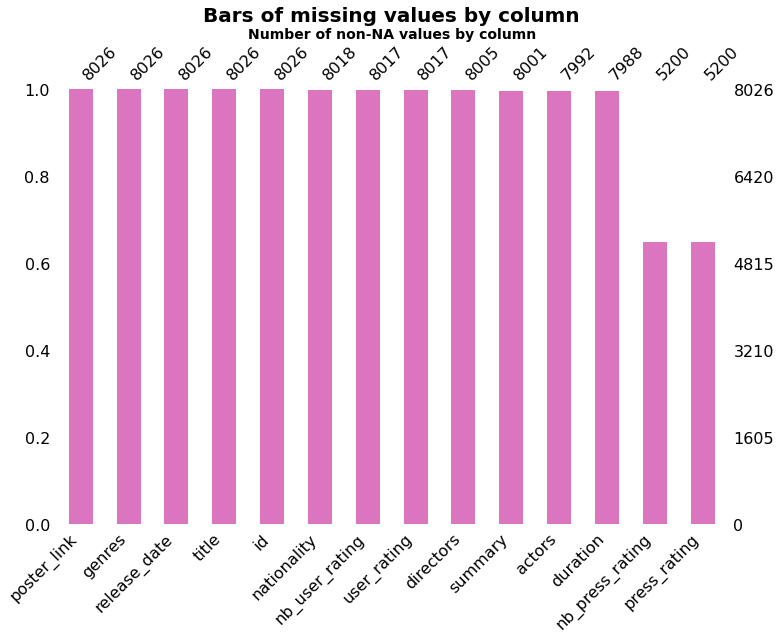

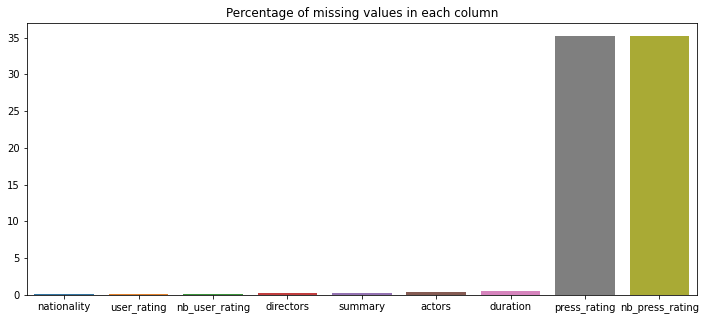

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8026 entries, 0 to 8025
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8026 non-null   int64  
 1   title            8026 non-null   object 
 2   release_date     8026 non-null   object 
 3   duration         7988 non-null   float64
 4   genres           8026 non-null   object 
 5   directors        8005 non-null   object 
 6   actors           7992 non-null   object 
 7   nationality      8018 non-null   object 
 8   press_rating     5200 non-null   float64
 9   nb_press_rating  5200 non-null   float64
 10  user_rating      8017 non-null   float64
 11  nb_user_rating   8017 non-null   float64
 12  summary          8001 non-null   object 
 13  poster_link      8026 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 878.0+ KB


,count,mean,std,min,25%,50%,75%,max
id,8026.0,150688.183529,104595.612810,1.0,37259.5,176807.5,250685.5,303494.0
duration,7988.0,107.992489,21.608678,26.0,95.0,104.0,118.0,450.0
press_rating,5200.0,3.247538,0.737270,1.0,2.8,3.3,3.7,5.0
nb_press_rating,5200.0,17.497885,8.647640,1.0,11.0,18.0,24.0,45.0
user_rating,8017.0,3.143059,0.733237,0.8,2.6,3.3,3.7,4.6
nb_user_rating,8017.0,5613.947362,13079.942641,1.0,396.0,1511.0,4746.0,218842.0


In [9]:
display_stats(m_unclean, "bar")

### Series

In [10]:
s_unclean = series.copy()

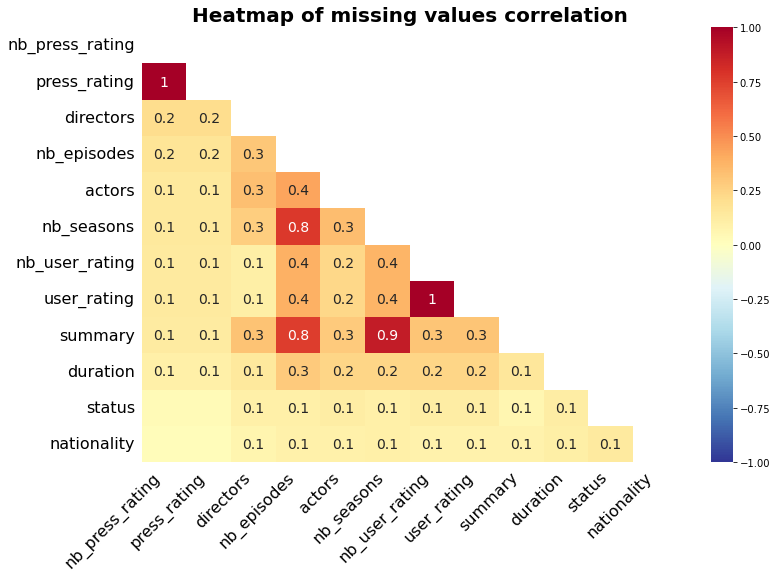

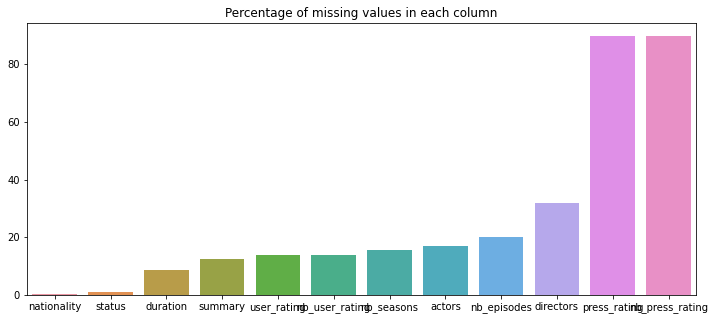

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8126 non-null   int64  
 1   title            8126 non-null   object 
 2   status           8048 non-null   object 
 3   release_date     8126 non-null   object 
 4   duration         7420 non-null   float64
 5   nb_seasons       6859 non-null   float64
 6   nb_episodes      6508 non-null   float64
 7   genres           8126 non-null   object 
 8   directors        5547 non-null   object 
 9   actors           6759 non-null   object 
 10  nationality      8094 non-null   object 
 11  press_rating     833 non-null    float64
 12  nb_press_rating  833 non-null    float64
 13  user_rating      7006 non-null   float64
 14  nb_user_rating   7006 non-null   float64
 15  summary          7117 non-null   object 
 16  poster_link      8126 non-null   object 
dtypes: float64(7),

,count,mean,std,min,25%,50%,75%,max
id,8126.0,15548.236402,9571.320117,1.0,6256.25,17480.5,24203.25,31807.0
duration,7420.0,40.674798,20.811908,1.0,25.00,42.0,52.00,240.0
nb_seasons,6859.0,2.403995,3.129590,1.0,1.00,1.0,3.00,59.0
nb_episodes,6508.0,41.359096,238.676016,1.0,8.00,14.0,38.00,13484.0
press_rating,833.0,3.249100,0.616424,1.3,2.90,3.3,3.70,5.0
nb_press_rating,833.0,8.099640,3.533958,1.0,6.00,8.0,10.00,30.0
user_rating,7006.0,3.273351,0.517935,0.8,3.00,3.2,3.60,4.7
nb_user_rating,7006.0,990.761205,5741.767257,1.0,7.00,37.0,199.00,206012.0


In [11]:
display_stats(s_unclean, "heatmap")

### Ratings

#### Movies Press Ratings

In [12]:
mp_unclean = press_movies.copy()

In [13]:
display_stats(mp_unclean, "matrix")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90040 entries, 0 to 90039
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    90040 non-null  object 
 1   movie_id      90040 non-null  int64  
 2   press_rating  90040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


,count,mean,std,min,25%,50%,75%,max
movie_id,90040.0,171023.777255,87568.777968,4.0,109544.0,195051.0,247579.0,302334.0
press_rating,90040.0,3.301932,1.110021,0.5,3.0,3.0,4.0,5.0


#### Movies User Ratings

In [14]:
mu_unclean = user_movies.copy()

In [15]:
display_stats(mu_unclean, "matrix")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330413 entries, 0 to 330412
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      330413 non-null  object 
 1   user_name    330413 non-null  object 
 2   movie_id     330413 non-null  int64  
 3   user_rating  330413 non-null  float64
 4   date         330413 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 12.6+ MB


,count,mean,std,min,25%,50%,75%,max
movie_id,330413.0,140231.740634,100803.699732,1.0,32758.0,140005.0,237510.0,303478.0
user_rating,330413.0,3.079087,1.202838,0.5,2.5,3.0,4.0,5.0


#### Series Press Ratings

In [16]:
sp_unclean = press_series.copy()

In [17]:
display_stats(sp_unclean, "matrix")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    6732 non-null   object 
 1   series_id     6732 non-null   int64  
 2   press_rating  6732 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 157.9+ KB


,count,mean,std,min,25%,50%,75%,max
series_id,6732.0,19525.694444,6235.905184,49.0,17052.0,21505.0,24084.0,31130.0
press_rating,6732.0,3.293672,0.971661,0.5,2.5,3.5,4.0,5.0


#### Series User Ratings

In [18]:
su_unclean = user_series.copy()

In [19]:
display_stats(su_unclean, "bar")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69946 entries, 0 to 69945
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      69946 non-null  object 
 1   user_name    69946 non-null  object 
 2   series_id    69946 non-null  int64  
 3   user_rating  69946 non-null  float64
 4   date         69946 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.7+ MB


,count,mean,std,min,25%,50%,75%,max
series_id,69946.0,14716.302390,9485.358350,1.0,4536.0,17565.0,23415.0,31804.0
user_rating,69946.0,3.481121,1.424246,0.5,2.5,4.0,4.5,5.0


### Summary

In [20]:
data_unclean = {"movies": m_unclean, "series": s_unclean, "press_movies": mp_unclean, "user_movies": mu_unclean, "press_series": sp_unclean, "user_series": su_unclean}

In [21]:
display_summary_table(data_unclean)

,Nb rows,Nb columns,Nb duplicates,Nb unique item,Nb items w/ press ratings,Nb items w/ press reviews,Nb items w/ user ratings,Nb items w/ user reviews
Movies,8026,14,119.0,7907.0,5111.0,5112.0,7898.0,7806.0
Series,8126,17,125.0,8001.0,792.0,792.0,6883.0,4775.0
Press_Movies,90040,3,1700.0,88340.0,NaN,NaN,NaN,NaN
User_Movies,330413,5,5224.0,325189.0,NaN,NaN,NaN,NaN
Press_Series,6732,3,335.0,6397.0,NaN,NaN,NaN,NaN
User_Series,69946,5,3449.0,66497.0,NaN,NaN,NaN,NaN


By looking at this summary table, we will focus our interest on the columns related to the number of ratings and reviews (from both press and users) on the number of unique movies and series. We got the number of items (movies and series) with ratings from the `Movies` and `Series` dataframes and the number of items with reviews from the `Ratings` dataframes. The latter corresponds to the number of movies/series from which we were able to collect the ratings data from individual users. To do so, we used the movies/series ID to get directly to the review page. At first, we would expect the number of items with ratings to be the same as the number of items with reviews, but as we can see, this is not the case. This noticeable difference can be explained by several reasons:
- If the the **number of items with ratings** is ***lower than*** the **number of items with reviews**, it means that:
    - some items don't have any reviews
    - the review page is unavailable
    - the reviews were made by "`Visitors`" (people with no account) from whom no data can be collected to build a user profile. 
- If the **number of items with ratings** is ***higher than*** the **number of items with reviews**, it means that:
    - some items were updated on the website by the time we could collect all the data (e.g. a movie with no press ratings received some press ratings between the time it was scraped and the time we collected its rating data).

## Dropping rows

### Duplicates

In [22]:
m_duplicates = movies.duplicated(subset=["id"]).sum()
s_duplicates = series.duplicated(subset=["id"]).sum()
pm_duplicates = press_movies.duplicated().sum()
ps_duplicates = press_series.duplicated().sum()
um_duplicates = user_movies.duplicated().sum()
us_duplicates = user_series.duplicated().sum()
print(f"Nb of movie duplicates: {m_duplicates}")
print(f"Nb of series duplicates: {s_duplicates}")
print(f"Nb of press movie duplicates: {pm_duplicates}")
print(f"Nb of press series duplicates: {ps_duplicates}")
print(f"Nb of user movie duplicates: {um_duplicates}")
print(f"Nb of user series duplicates: {us_duplicates}")
series.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
movies.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
press_movies.drop_duplicates(inplace=True, ignore_index=True)
press_series.drop_duplicates(inplace=True, ignore_index=True)
user_movies.drop_duplicates(inplace=True, ignore_index=True)
user_series.drop_duplicates(inplace=True, ignore_index=True)
print("--> All duplicates removed")

Nb of movie duplicates: 119
Nb of series duplicates: 125
Nb of press movie duplicates: 1700
Nb of press series duplicates: 335
Nb of user movie duplicates: 5224
Nb of user series duplicates: 3449
--> All duplicates removed


### Other

In [23]:
# Drop series with "Divers" as genre (lots of missing values)
series_divers = series[series.genres.apply(lambda x: "Divers" in x)]
series.drop(series_divers.index, inplace=True)
print(f"--> {len(series_divers)} 'Divers' series removed")

--> 18 'Divers' series removed


In [24]:
series_divers.tail()

,id,title,status,release_date,duration,nb_seasons,nb_episodes,genres,directors,actors,nationality,press_rating,nb_press_rating,user_rating,nb_user_rating,summary,poster_link
7338,25466,Bong Appetit,En cours,Depuis 2016,44.0,3.0,NaN,Divers,NaN,NaN,U.S.A.,NaN,NaN,NaN,NaN,"B Real, Vanessa Lavorato et Miguel Trinidad an...",https://fr.web.img6.acsta.net/c_310_420/pictur...
7428,21493,Brillante Mendoza Presents,Terminée,Depuis2017,NaN,1.0,NaN,Divers,Brillante Mendoza,NaN,NaN,NaN,NaN,NaN,NaN,Une série de programmes mensuels créés par le ...,https://fr.web.img6.acsta.net/c_310_420/pictur...
7558,8328,Canterbury Tales,Terminée,2003,NaN,NaN,NaN,Divers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fr.web.img6.acsta.net/c_310_420/common...
7715,18734,Christine Cromwell,Terminée,1989-1990,NaN,1.0,4.0,Divers,NaN,"Jaclyn Smith, Jason Beghe",NaN,NaN,NaN,NaN,NaN,Les enquêtes de Christine Cromwell...,https://fr.web.img6.acsta.net/c_310_420/common...
7766,29315,Claude,NaN,Depuis 2017,NaN,NaN,NaN,Divers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fr.web.img6.acsta.net/c_310_420/common...


In [25]:
# Drop series with "Datedesortieinconnue" as release_date (lots of missing values)
s_unknown_release_date = series[series.release_date == "Datedesortieinconnue"]
series.drop(s_unknown_release_date.index, inplace=True)
series.reset_index(drop=True, inplace=True)
print(f"--> {len(s_unknown_release_date)} series with unknown release date removed")

--> 4 series with unknown release date removed


In [26]:
s_unknown_release_date

,id,title,status,release_date,duration,nb_seasons,nb_episodes,genres,directors,actors,nationality,press_rating,nb_press_rating,user_rating,nb_user_rating,summary,poster_link
5270,8390,Les Baskerville : une famille d'enfer,Terminée,Datedesortieinconnue,26.0,NaN,NaN,Animation,NaN,NaN,NaN,NaN,NaN,3.1,2.0,NaN,https://fr.web.img6.acsta.net/c_310_420/common...
6449,9832,5. Boyut,Terminée,Datedesortieinconnue,NaN,NaN,NaN,Drame,NaN,NaN,Turquie,NaN,NaN,NaN,NaN,NaN,https://fr.web.img6.acsta.net/c_310_420/common...
7269,8847,Blaise le blasé,Terminée,Datedesortieinconnue,22.0,NaN,NaN,Animation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fr.web.img6.acsta.net/c_310_420/common...
7793,8366,Co2,Terminée,Datedesortieinconnue,2.0,NaN,NaN,Animation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fr.web.img6.acsta.net/c_310_420/common...


## Convert CSV strings to arrays

In [27]:
def convert_to_array(df: pd.DataFrame):
    '''
    Convert CSV strings values into arrays.
    :param df: dataframe in which we convert CSV strings values into arrays.
    :return: None
    '''
    df["genres"] = df["genres"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["directors"] = df["directors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["actors"] = df["actors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["nationality"] = df["nationality"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)

In [28]:
convert_to_array(movies)
convert_to_array(series)

## Create new tables

### *GENRE*

#### *Rename `Drama` to `Drame`*

In [29]:
for index, row in series.iterrows():
    series.at[index,"genres"] = list(set(map(lambda x: x.replace("Drama", "Drame"), series.loc[index,"genres"])))

#### *Create `genres` dataframes*

In [30]:
def create_genre_df(df_key: str):
    '''
    Create a dataframe that contains information about each genre.
    :param df_key: The dataframe key of the data dict to get the genres from (movies or series).
    :return: The movies or series genre dataframe.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    genre_df = None
    if df is not None:  
        df = df.copy()      
        # Remove all rows with no genres
        df.dropna(subset=["genres"], inplace=True)
        # Get all unique genres from df
        genres_list = [genre.lstrip() for genres in df["genres"] for genre in genres]
        genres_list = sorted(list(set(genres_list))) 

        # Create dataframe with the number of movies/series per genre from genres_list
        genre_df = pd.DataFrame({"genres": genres_list, f"nb_{df_key}": [df[df["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres_list]})

        # Add the average duration per genre
        genre_df["avg_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].mean()) for genre in genres_list]

        # Add the median duration per genre
        genre_df["median_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].median()) for genre in genres_list]

        # Add the nb_press_rating and nb_user_rating to the genre_df
        genre_df["nb_press_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum()) for genre in genres_list]
        genre_df["nb_user_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum()) for genre in genres_list]

        # Add the total_rating to the genre_df (press_rating + user_rating)
        genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the genre_df 
        genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 3)
        genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 3)

        # Add the movies/series_percentage to the genre_df
        genre_df[f"{df_key}_percentage"] = round(genre_df[f"nb_{df_key}"]/df.shape[0] * 100, 3)
        # Return the genre_df sorted by genre
        return genre_df.sort_values(by = "genres", ascending = True)

In [31]:
m_genres_df = create_genre_df("movies")
s_genres_df = create_genre_df("series")

In [32]:
print(m_genres_df.genres.values)
print(s_genres_df.genres.values)

['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Bollywood'
 'Comédie' 'Comédie dramatique' 'Comédie musicale' 'Divers' 'Drame'
 'Epouvante-horreur' 'Erotique' 'Espionnage' 'Expérimental' 'Famille'
 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Musical' 'Policier'
 'Péplum' 'Romance' 'Science fiction' 'Sport event' 'Thriller' 'Western']
['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Classique'
 'Comédie' 'Comédie dramatique' 'Comédie musicale' 'Dessin animé'
 'Documentaire' 'Drame' 'Epouvante-horreur' 'Erotique' 'Espionnage'
 'Famille' 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Mobisode'
 'Musical' 'Médical' 'Policier' 'Péplum' 'Romance' 'Science fiction'
 'Show' 'Soap' 'Sport event' 'Thriller' 'Websérie' 'Western']


In [33]:
m_genres_df

,genres,nb_movies,avg_duration,median_duration,nb_press_rating,nb_user_rating,total_rating,press_rating_percentage,user_rating_percentage,movies_percentage
0,Action,1275,112,110,12795,12131275,12144070,7.493,12.933,16.125
1,Animation,499,90,91,6605,3124143,3130748,3.868,3.331,6.311
2,Arts Martiaux,40,106,105,275,97131,97406,0.161,0.104,0.506
3,Aventure,868,111,106,9946,8799177,8809123,5.825,9.380,10.978
4,Biopic,346,122,119,5077,1566343,1571420,2.973,1.670,4.376
5,Bollywood,8,164,168,50,3618,3668,0.029,0.004,0.101
6,Comédie,2001,100,99,23074,11823748,11846822,13.512,12.605,25.307
7,Comédie dramatique,451,108,105,5114,1683534,1688648,2.995,1.795,5.704
8,Comédie musicale,78,114,113,974,545628,546602,0.570,0.582,0.986
9,Divers,4,127,150,0,95,95,0.000,0.000,0.051


#### *Save all `genres` dataframes*

In [34]:
path = "../Cleaned Data/"
save_data(m_genres_df, path, "m_genres")
save_data(s_genres_df, path, "s_genres")

File successfully saved in ../Cleaned Data/m_genres.csv
File successfully saved in ../Cleaned Data/s_genres.csv


### *NATIONALITY*

#### *Create `nationality` dataframes*

In [35]:
def create_nationality_df(df_key: str):
    '''
    Create a dataframe that contains information about each nationality.
    :param df_key: The dataframe key of the data dict to get the nationalities from (movies or series).
    :return: The movies or series nationality dataframe.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    nation_df = None
    if df is not None:        
        df = df.copy()
        # Remove all rows with no nationality
        df.dropna(subset=["nationality"], inplace=True)
        # Get all unique nationality from df
        nationality = [nat.lstrip() for nationality in df["nationality"] for nat in nationality]
        nationality = sorted(list(set(nationality))) 
        # Create dataframe with the number of movies/series per nationality from nationality list
        nation_df = pd.DataFrame({"nationality": nationality, f"nb_{df_key}": [df[df["nationality"].apply(lambda x: nation in x).values].shape[0] for nation in nationality]})

        # Add the nb_press_rating and nb_user_rating to the nation_df
        nation_df["nb_press_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_press_rating"].sum()) for nation in nationality]
        nation_df["nb_user_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_user_rating"].sum()) for nation in nationality]

        # Add the total_rating to the nation_df (press_rating + user_rating)
        nation_df["total_rating"] = nation_df["nb_press_rating"] + nation_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the nation_df 
        nation_df["press_rating_percentage"] = round(nation_df["nb_press_rating"] / nation_df["nb_press_rating"].values.sum() * 100, 4)
        nation_df["user_rating_percentage"] = round(nation_df["nb_user_rating"] / nation_df["nb_user_rating"].values.sum() * 100, 4)

        # Add the movies/series_percentage to the nation_df
        nation_df[f"{df_key}_percentage"] = round(nation_df[f"nb_{df_key}"]/df.shape[0] * 100, 4)
        return nation_df.sort_values(by = "nationality", ascending = True)

In [36]:
m_nationality_df = create_nationality_df("movies")
s_nationality_df = create_nationality_df("series")

In [37]:
print(m_nationality_df.nationality.values)
print(s_nationality_df.nationality.values)

['Albania' 'Algeria' 'Argentina' 'Armenia' 'Australia' 'Austria' 'Belgium'
 'Benin' 'Bolivia' 'Bosnia' 'Botswana' 'Brazil' 'Bulgaria' 'Byelorussia'
 'Cambodia' 'Canada' 'Chad' 'Chile' 'China' 'Colombia' 'Croatia' 'Cuba'
 'Cyprus' 'Czech Republic' 'Czechoslovakia' 'Denmark' 'Dominican Republic'
 'Egypt' 'Estonia' 'Ethiopia' 'Finland' 'France' 'Georgia' 'Germany'
 'Greece' 'Guatemala' 'Guinea' 'Haiti' 'Hongkong' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Ireland' 'Israel' 'Italy' 'Ivory Coast'
 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea' 'Kosovo' 'Laos' 'Latvia'
 'Lebanon' 'Libia' 'Liechtenstein' 'Lithuania' 'Luxembourg' 'Malawi'
 'Malaysia' 'Malta' 'Mauritania' 'Mexico' 'Monaco' 'Mongolia' 'Morocco'
 'Nepal' 'Netherlands' 'New Zealand' 'Nigeria' 'Norway' 'Pakistan'
 'Palestine' 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Russia' 'Rwanda' 'Samoa' 'Saudi Arabia' 'Senegal'
 'Serbia' 'Singapore' 'Slovakia' 'Slovenia' 'Somalia' 'South Africa'
 'So

In [38]:
m_nationality_df

,nationality,nb_movies,nb_press_rating,nb_user_rating,total_rating,press_rating_percentage,user_rating_percentage,movies_percentage
0,Albania,1,0,3,3,0.0000,0.0000,0.0127
1,Algeria,10,141,21713,21854,0.1062,0.0359,0.1266
2,Argentina,27,361,47775,48136,0.2720,0.0791,0.3418
3,Armenia,1,16,203,219,0.0121,0.0003,0.0127
4,Australia,126,1266,693229,694495,0.9537,1.1475,1.5951
...,...,...,...,...,...,...,...,...
107,United Kingdom,810,9930,5776055,5785985,7.4807,9.5613,10.2545
108,Uruguay,3,59,1217,1276,0.0444,0.0020,0.0380
109,Venezuela,1,17,704,721,0.0128,0.0012,0.0127
110,Vietnam,2,31,11658,11689,0.0234,0.0193,0.0253


#### *Save all `nationality` dataframes*

In [39]:
path = "../Cleaned Data/"
save_data(m_nationality_df, path, "m_nationality")
save_data(s_nationality_df, path, "s_nationality")

File successfully saved in ../Cleaned Data/m_nationality.csv
File successfully saved in ../Cleaned Data/s_nationality.csv


## Improve data format & coherence

### Impute missing duration

In [40]:
def impute_missing_duration(df_key: str):
    '''
    From the m/s_genres_df DataFrames, we order the genres by the amount of movies/series with that genre.
    We then compute the median duration of the movies/series with that genre.
    Finally, we impute the missing duration of the movies/series with the median duration of the movies/series with the most popular genre among their genres.
    We choose the median as it is more robust than the mean duration.
    :param df_key: Key of the dataframe in the data dictionary to impute the missing duration from.
    :return: The imputed dataframe.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    genres_df = m_genres_df if df_key == "movies" else s_genres_df if df_key == "series" else None
    if df is not None:
        df = df.copy()
        # Get the movies/serie with missing duration
        df_na_duration = df[df["duration"].isna()]
        for index, row in df_na_duration.iterrows():
            # Get the genre rows of each movies/series genres from the m/s_genres_df DataFrame
            na_duration_genres = genres_df.loc[genres_df.genres.isin(row["genres"])]
            # Get the genre with the most movies/series from the na_duration_genres DataFrame
            most_pop_genre = na_duration_genres.sort_values(by = f"nb_{df_key}", ascending = False).iloc[0]["genres"]
            # Retrieve the median duration of the movies/series with the most popular genre
            median_duration = int(genres_df[genres_df.genres == most_pop_genre].median_duration)
            # Impute the missing duration of the movies/series with the median duration of the most popular genre
            df.loc[index, "duration"] = median_duration
    return df

### Series

In [41]:
series = impute_missing_duration("series")

#### Drop missing ratings and NA threshold

In [42]:
# Drop series with no press AND no user ratings
'''s_na_ratings = series[series["press_rating"].isna()][series["user_rating"].isna()].shape[0]
series.dropna(subset=["press_rating","user_rating"], inplace=True, how="all")
series.reset_index(drop=True, inplace=True)
print(f"Number of series with no ratings: {s_na_ratings}")
print("--> All series with no ratings removed")'''
# IT WILL BE USED LATER WHEN BUILDING THE RECOMMANDATION MODELS

's_na_ratings = series[series["press_rating"].isna()][series["user_rating"].isna()].shape[0]\nseries.dropna(subset=["press_rating","user_rating"], inplace=True, how="all")\nseries.reset_index(drop=True, inplace=True)\nprint(f"Number of series with no ratings: {s_na_ratings}")\nprint("--> All series with no ratings removed")'

In [43]:
# Drop series with at least na_thresh missing values
na_thresh = 7
# Dataframe with series with at least na_thresh missing values
s_na_thresh = series[series.apply(lambda x: sum(x.isna()) >= na_thresh, axis=1)]
series.drop(index=s_na_thresh.index, inplace=True)
series.reset_index(drop=True, inplace=True)
print(f"Number of series with at least {na_thresh} missing values: {len(s_na_thresh)}")
print(f"--> All series with at least {na_thresh} missing values removed")

Number of series with at least 7 missing values: 761
--> All series with at least 7 missing values removed


#### Change `release_date` format

In [44]:
# Replace the release_date string by the release year as a date (YYYY-MM-DD)
# As we don't have the exact date, we will by default use 01-01 as MM-DD, helping in date parsing for visualization.
# Get all the 4-digits numbers from a string and keep only the first one, which is the release year. 
series["release_date"] = series["release_date"].apply(lambda x: dateparser.parse(re.findall(r"\d{4}", x)[0] + "-01-01", date_formats=["%Y-%m-%d"]).date())

In [45]:
# Find the series where nb_seasons is greater or equal to nb_episodes 
series[series.nb_seasons > series.nb_episodes].shape

(14, 17)

### Movies

In [46]:
movies = impute_missing_duration("movies")

#### Drop missing ratings

In [47]:
# Drop series and movies with no press AND no user ratings
'''m_na_ratings = movies[movies["press_rating"].isna()][movies["user_rating"].isna()].shape[0]
movies.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
movies.reset_index(drop=True, inplace=True)
print(f"Number of movies with no ratings: {m_na_ratings}")
print("--> All movies with no ratings removed")'''
# IT WILL BE USED LATER WHEN BUILDING THE RECOMMANDATION MODELS

'm_na_ratings = movies[movies["press_rating"].isna()][movies["user_rating"].isna()].shape[0]\nmovies.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")\nmovies.reset_index(drop=True, inplace=True)\nprint(f"Number of movies with no ratings: {m_na_ratings}")\nprint("--> All movies with no ratings removed")'

#### Get the release season date

In [48]:
def get_release_season(date: str):
    '''
    Get the release season date (eg: from "2019-05-10" return "Spring")
    :param date: Date to get the release season from.
    :return: The release season of the movie.
    '''
    spring = "03-21"
    summer = "06-21"
    fall = "09-21"
    winter = "12-21"
    my = re.sub(r"\d{4}-", "", date)
    if my < spring or my >= winter:
        return "Winter"
    elif my < summer and my >= spring:
        return "Spring"
    elif my < fall and my >= summer:
        return "Summer"
    elif my < winter and my >= fall:
        return "Fall"

In [49]:
# Get the release season
movies["release_season"] = movies["release_date"].apply(lambda x: get_release_season(x))
movies_cols = movies_cols[:3] + ["release_season"] + movies_cols[3:]
movies = movies[movies_cols]

## Display the last stats

### Movies

In [50]:
m_clean = movies.copy()

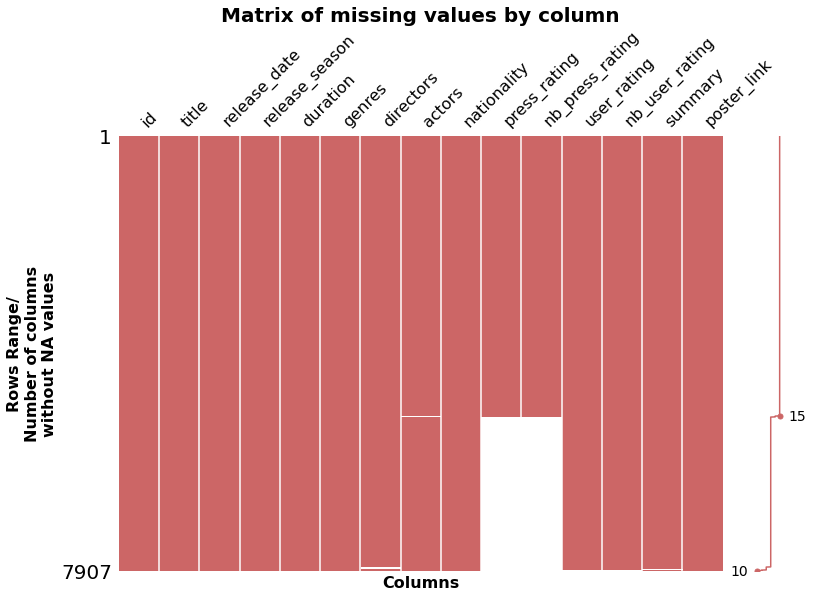

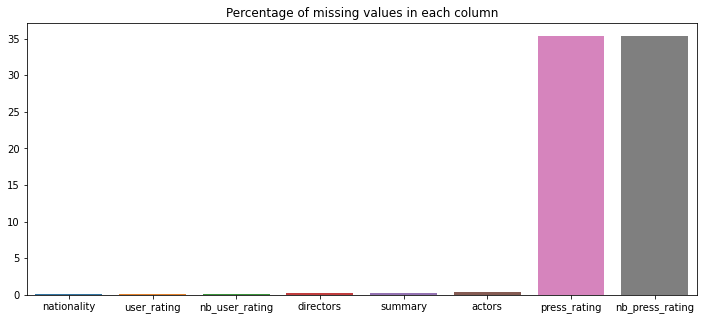

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7907 non-null   int64  
 1   title            7907 non-null   object 
 2   release_date     7907 non-null   object 
 3   release_season   7907 non-null   object 
 4   duration         7907 non-null   float64
 5   genres           7907 non-null   object 
 6   directors        7887 non-null   object 
 7   actors           7873 non-null   object 
 8   nationality      7899 non-null   object 
 9   press_rating     5111 non-null   float64
 10  nb_press_rating  5111 non-null   float64
 11  user_rating      7898 non-null   float64
 12  nb_user_rating   7898 non-null   float64
 13  summary          7882 non-null   object 
 14  poster_link      7907 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 926.7+ KB


,count,mean,std,min,25%,50%,75%,max
id,7907.0,150633.523713,104594.601583,1.0,37177.0,177009.0,250670.00,303494.0
duration,7907.0,107.910712,21.602160,26.0,95.0,104.0,118.00,450.0
press_rating,5111.0,3.247388,0.738463,1.0,2.8,3.3,3.70,5.0
nb_press_rating,5111.0,17.464880,8.656134,1.0,11.0,18.0,24.00,45.0
user_rating,7898.0,3.140491,0.732848,0.8,2.6,3.2,3.70,4.6
nb_user_rating,7898.0,5563.583059,12946.183790,1.0,394.0,1501.5,4724.75,218842.0


In [51]:
display_stats(m_clean, "matrix")

### Series

In [52]:
s_clean = series.copy()

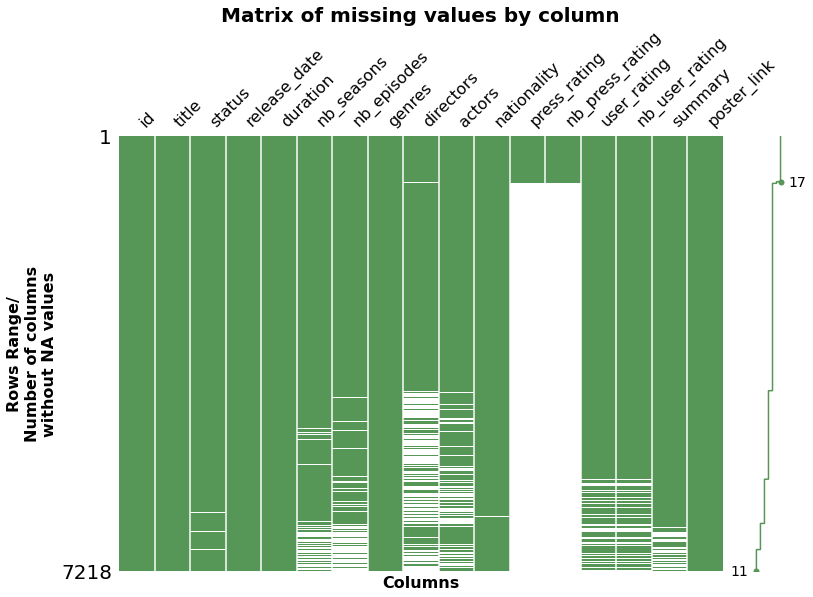

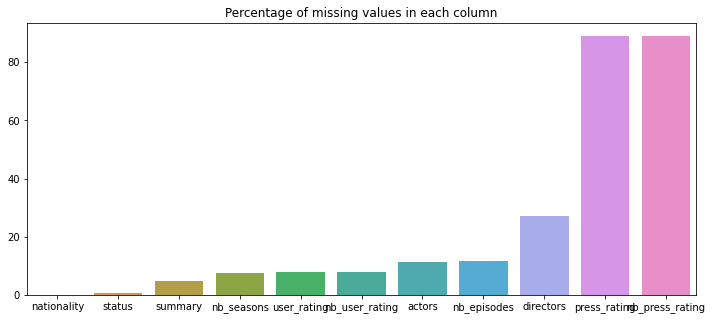

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7218 entries, 0 to 7217
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7218 non-null   int64  
 1   title            7218 non-null   object 
 2   status           7182 non-null   object 
 3   release_date     7218 non-null   object 
 4   duration         7218 non-null   float64
 5   nb_seasons       6682 non-null   float64
 6   nb_episodes      6377 non-null   float64
 7   genres           7218 non-null   object 
 8   directors        5251 non-null   object 
 9   actors           6401 non-null   object 
 10  nationality      7213 non-null   object 
 11  press_rating     792 non-null    float64
 12  nb_press_rating  792 non-null    float64
 13  user_rating      6656 non-null   float64
 14  nb_user_rating   6656 non-null   float64
 15  summary          6861 non-null   object 
 16  poster_link      7218 non-null   object 
dtypes: float64(7),

,count,mean,std,min,25%,50%,75%,max
id,7218.0,15907.882377,9717.005349,1.0,6014.5,18590.0,24516.75,31807.0
duration,7218.0,40.682738,20.080238,1.0,25.0,42.0,52.00,240.0
nb_seasons,6682.0,2.396438,3.139496,1.0,1.0,1.0,3.00,59.0
nb_episodes,6377.0,41.416026,241.004230,1.0,8.0,14.0,38.00,13484.0
press_rating,792.0,3.245202,0.611625,1.3,2.8,3.3,3.70,5.0
nb_press_rating,792.0,8.095960,3.528591,1.0,6.0,8.0,10.00,30.0
user_rating,6656.0,3.275451,0.521327,0.8,3.0,3.2,3.60,4.7
nb_user_rating,6656.0,995.076322,5819.471164,1.0,8.0,39.0,200.00,206012.0


In [53]:
display_stats(s_clean, "matrix")

### Ratings

#### Movies Press Ratings

In [54]:
mp_clean = press_movies.copy()

In [55]:
display_stats(mp_clean, "matrix")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88340 entries, 0 to 88339
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    88340 non-null  object 
 1   movie_id      88340 non-null  int64  
 2   press_rating  88340 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ MB


,count,mean,std,min,25%,50%,75%,max
movie_id,88340.0,170869.956860,87518.317516,4.0,109551.0,195021.0,247450.0,302334.0
press_rating,88340.0,3.301755,1.110449,0.5,3.0,3.0,4.0,5.0


#### Movies User Ratings

In [56]:
mu_clean = user_movies.copy()

In [57]:
display_stats(mu_clean, "matrix")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325189 entries, 0 to 325188
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      325189 non-null  object 
 1   user_name    325189 non-null  object 
 2   movie_id     325189 non-null  int64  
 3   user_rating  325189 non-null  float64
 4   date         325189 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 12.4+ MB


,count,mean,std,min,25%,50%,75%,max
movie_id,325189.0,140130.186965,100795.251563,1.0,32704.0,139966.0,237415.0,303478.0
user_rating,325189.0,3.076469,1.202988,0.5,2.5,3.0,4.0,5.0


#### Series Press Ratings

In [58]:
sp_clean = press_series.copy()

In [59]:
display_stats(sp_clean, "matrix")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6397 entries, 0 to 6396
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    6397 non-null   object 
 1   series_id     6397 non-null   int64  
 2   press_rating  6397 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 150.1+ KB


,count,mean,std,min,25%,50%,75%,max
series_id,6397.0,19505.837267,6273.479267,49.0,17052.0,21394.0,24084.0,31130.0
press_rating,6397.0,3.288573,0.971393,0.5,2.5,3.5,4.0,5.0


#### Series User Ratings

In [60]:
su_clean = user_series.copy()

In [61]:
display_stats(su_clean, "bar")

No missing values in the dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      66497 non-null  object 
 1   user_name    66497 non-null  object 
 2   series_id    66497 non-null  int64  
 3   user_rating  66497 non-null  float64
 4   date         66497 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.5+ MB


,count,mean,std,min,25%,50%,75%,max
series_id,66497.0,14674.014151,9510.309961,1.0,4509.0,17483.0,23405.0,31804.0
user_rating,66497.0,3.482879,1.425350,0.5,2.5,4.0,4.5,5.0


### Summary

In [62]:
data_cleaned = {"movies": m_clean, "series": s_clean, "press_movies": mp_clean, "press_series": sp_clean, "user_movies": mu_clean, "user_series": su_clean}

In [63]:
display_summary_table(data_cleaned)

,Nb rows,Nb columns,Nb duplicates,Nb unique item,Nb items w/ press ratings,Nb items w/ press reviews,Nb items w/ user ratings,Nb items w/ user reviews
Movies,7907,15,0.0,7907.0,5111.0,5112.0,7898.0,7806.0
Series,7218,17,0.0,7218.0,792.0,792.0,6656.0,4775.0
Press_Movies,88340,3,0.0,88340.0,NaN,NaN,NaN,NaN
Press_Series,6397,3,0.0,6397.0,NaN,NaN,NaN,NaN
User_Movies,325189,5,0.0,325189.0,NaN,NaN,NaN,NaN
User_Series,66497,5,0.0,66497.0,NaN,NaN,NaN,NaN


## Save Cleaned datasets

In [64]:
path = "../Cleaned Data/"
for k,v in data_cleaned.items():
    save_data(v, path, k)

File successfully saved in ../Cleaned Data/movies.csv
File successfully saved in ../Cleaned Data/series.csv
File successfully saved in ../Cleaned Data/press_movies.csv
File successfully saved in ../Cleaned Data/press_series.csv
File successfully saved in ../Cleaned Data/user_movies.csv
File successfully saved in ../Cleaned Data/user_series.csv


---
# **Section 1. Ratings Distribution**


## Plot the Distribution of Ratings 

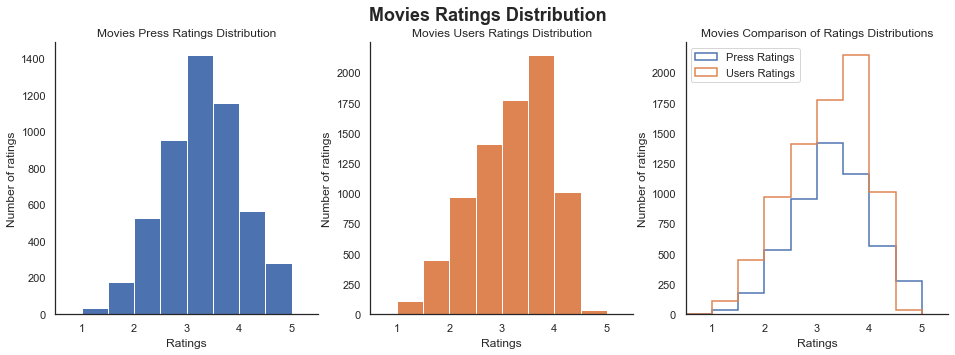

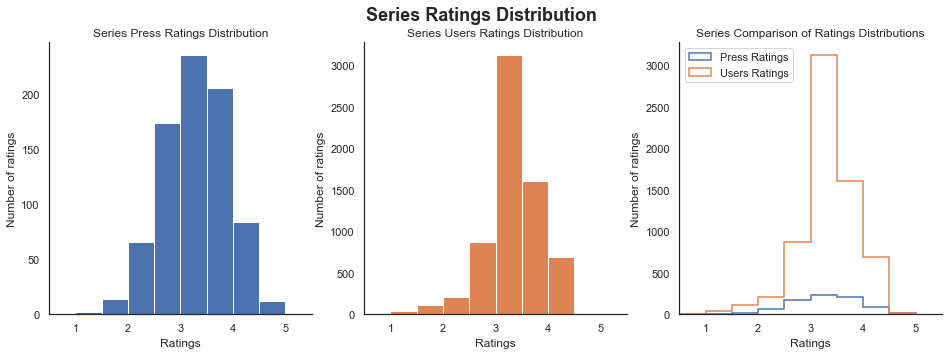

In [65]:
for k,df in list(data_cleaned.items())[:2]:
        sns.set(style="white", palette="deep")

        fig, axes = plt.subplots(1, 3, figsize = (16,5))
        fig.suptitle(f"{k.title()} Ratings Distribution", fontsize=18, fontweight='bold')
        ax1, ax2, ax3 = fig.axes

        ax1.set_xlim([0.5,5.5])
        ax2.set_xlim([0.5,5.5])
        ax3.set_xlim([0.5,5.5])

        ax1.hist(df["press_rating"], bins = 10, range = (0,5), color='C0') # bin range = 1
        ax1.set_title(f'{k.title()} Press Ratings Distribution')
        ax1.set_xlabel('Ratings')
        ax1.set_ylabel('Number of ratings')

        ax2.hist(df["user_rating"], bins = 10, range = (0,5), color='C1') # bin range = 1
        ax2.set_title(f'{k.title()} Users Ratings Distribution')
        ax2.set_xlabel('Ratings')
        ax2.set_ylabel('Number of ratings')

        ax3.hist(df["press_rating"], bins = 10, range = (0,5), histtype = 'step', 
                lw=1.5, label='Press Ratings', color='C0')
        ax3.hist(df["user_rating"], bins = 10, range = (0,5), histtype = 'step', 
                lw=1.5, label='Users Ratings', color='C1')
        ax3.legend(loc = 'upper left')
        ax3.set_title(f'{k.title()} Comparison of Ratings Distributions')
        ax3.set_xlabel('Ratings')
        ax3.set_ylabel('Number of ratings')

        for ax in fig.axes:
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
        # Save the figures
        fig.savefig(f"{k}_rating_dist.png", bbox_inches='tight', dpi=200)

## Ratings Correlation

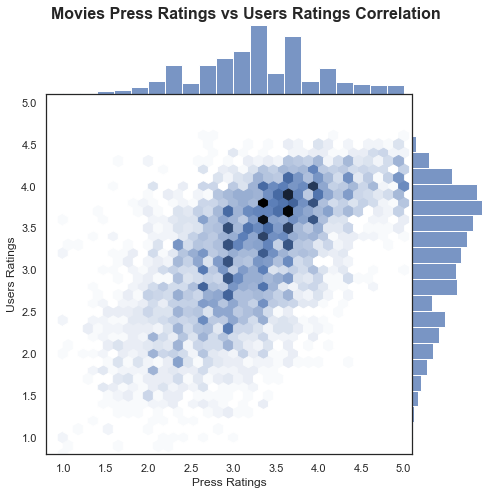

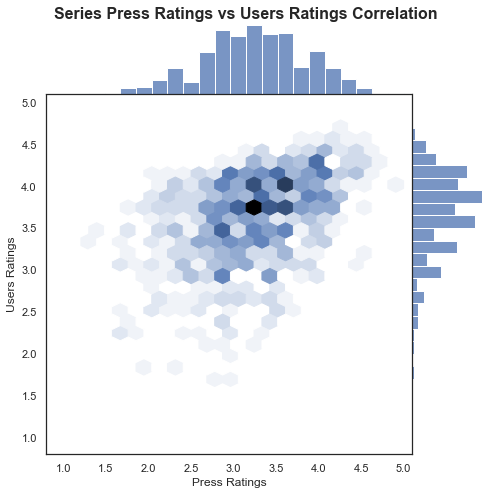

In [66]:
# Correlation between press_rating and user_rating
for k,df in list(data_cleaned.items())[:2]:
    ax = sns.jointplot(x="press_rating", y="user_rating", 
                    data=df, kind="hex",
                    marginal_kws=dict(bins=20),
                    xlim=(0.8,5.1), ylim=(0.8,5.1),
                    height=7, space=0)
    ax.set_axis_labels("Press Ratings", "Users Ratings")
    ax.fig.suptitle(f"{k.title()} Press Ratings vs Users Ratings Correlation", fontsize=16, fontweight='bold')
    ax.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    # save the fig
    ax.savefig(f"{k}_press_user_corr.png", bbox_inches='tight', dpi=200)

## Compare users to press ratings

In [67]:
def compare_max_ratings(rating_from: str, rating_to: str):
    '''
    Compare the (user|press) ratings of movies and series for which the (press|user) gave the highest rating.
    :param rating_from: The dataset to compare the max ratings from (user|press).
    :param rating_to: The dataset to compare the max ratings to (press|user).
    '''
    try:
        max_rating = 4.5 if rating_to == "user" else 5 
        # The max rating for user is 4.6 but we get more data to compare with if we use 4.5 and above.
        for k,df in list(data_cleaned.items())[:2]:
            five_stars = df[df[f"{rating_to}_rating"] >= max_rating]
            f, ax = plt.subplots(figsize=(15,6))
            f.suptitle(f'{k.title()} with {max_rating} Stars From The {rating_to.title()}', fontsize=18, fontweight='bold')
            f.subplots_adjust(top=0.85)

            sns.countplot(x=five_stars[f"{rating_from}_rating"], ax=ax)
            ax.set_xlabel(f"{rating_from.title()} Ratings")
            ax.set_ylabel("Number of ratings")
            sns.despine(top=True, right=True, left=False, bottom=False)
            
            ### print the first tier and second tier of the User Ratings
            print(f"\n{k.upper()} {rating_from} RATINGS TIER DISTRIBUTION")
            quant = df[[f"{rating_from}_rating"]].quantile([.33,.66])
            print(quant)
            
            p = (len(five_stars[(five_stars[f"{rating_from}_rating"] < quant.values[0][0])]) / len(five_stars)) * 100
            print(f'{round(p, 2)} % of the {k.title()} with the highest {rating_to} ratings received a low {rating_from} ratings.')
            p = (len(five_stars[(five_stars[f"{rating_from}_rating"] < quant.values[1][0]) & (five_stars[f"{rating_from}_rating"] >= quant.values[0][0])]) / len(five_stars)) * 100
            print(f'{round(p, 2)} % of the {k.title()} with the highest {rating_to} ratings received a moderate {rating_from} ratings.')
            p = (len(five_stars[five_stars[f"{rating_from}_rating"] >= quant.values[1][0]]) / len(five_stars)) * 100
            print(f'{round(p, 2)} % of the {k.title()} with the highest {rating_to} ratings received a high {rating_from} ratings.')
            
            ### save the fig
            f.savefig(f'{k}_max_{rating_to}.png', bbox_inches='tight', dpi=200)
    except Exception as e:
        print(f"Error in compare_max_ratings:\n {e} is not a valid rating type.")


MOVIES user RATINGS TIER DISTRIBUTION
      user_rating
0.33          2.8
0.66          3.6
0.0 % of the Movies with the highest press ratings received a low user ratings.
4.95 % of the Movies with the highest press ratings received a moderate user ratings.
95.05 % of the Movies with the highest press ratings received a high user ratings.

SERIES user RATINGS TIER DISTRIBUTION
      user_rating
0.33          3.1
0.66          3.5
0.0 % of the Series with the highest press ratings received a low user ratings.
0.0 % of the Series with the highest press ratings received a moderate user ratings.
100.0 % of the Series with the highest press ratings received a high user ratings.


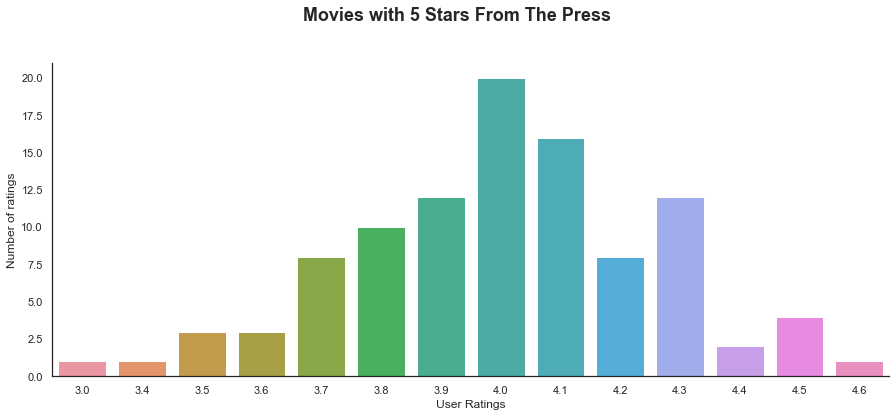

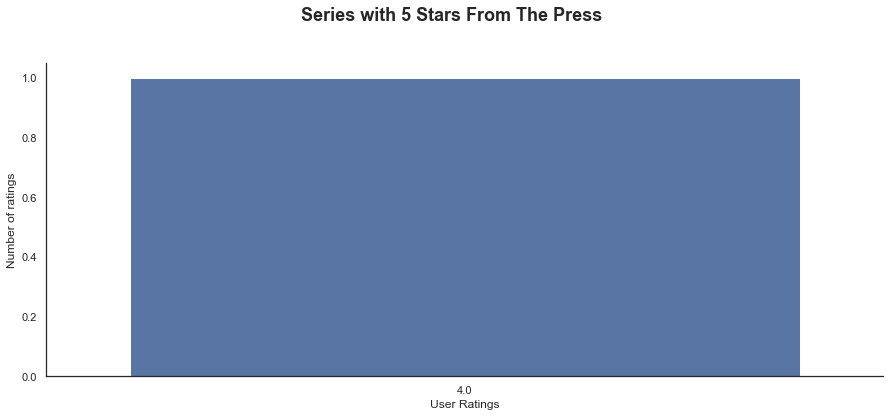

In [68]:
compare_max_ratings(rating_from="user", rating_to="press")

## Compare press to users ratings


MOVIES press RATINGS TIER DISTRIBUTION
      press_rating
0.33           2.9
0.66           3.5
9.38 % of the Movies with the highest user ratings received a low press ratings.
6.25 % of the Movies with the highest user ratings received a moderate press ratings.
84.38 % of the Movies with the highest user ratings received a high press ratings.

SERIES press RATINGS TIER DISTRIBUTION
      press_rating
0.33           3.0
0.66           3.5
0.0 % of the Series with the highest user ratings received a low press ratings.
0.0 % of the Series with the highest user ratings received a moderate press ratings.
64.29 % of the Series with the highest user ratings received a high press ratings.


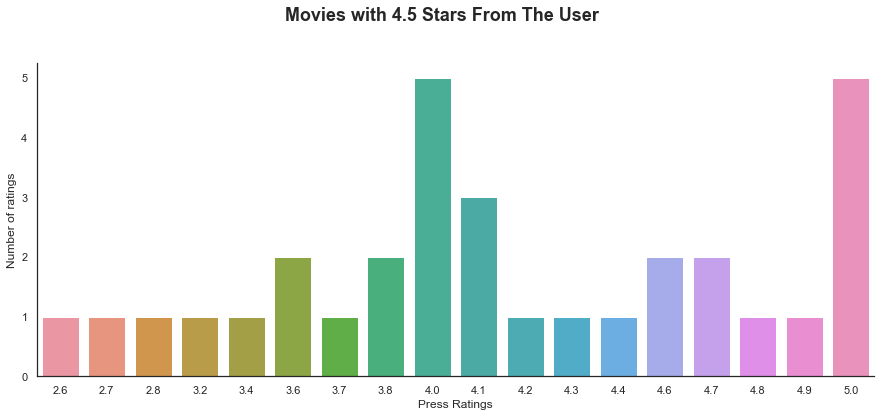

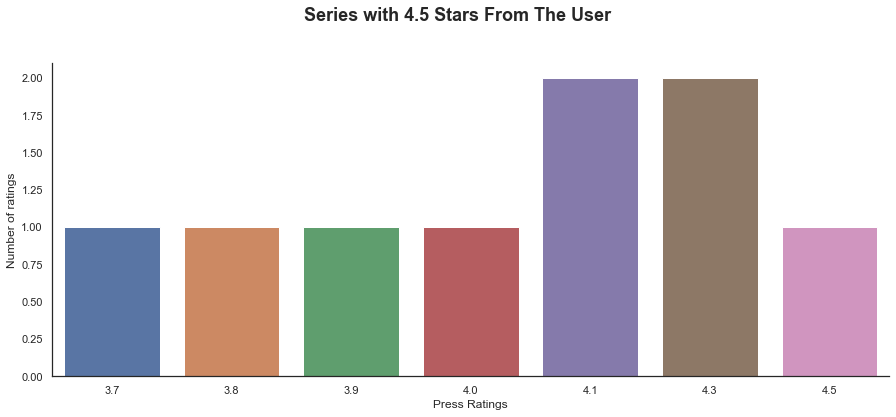

In [69]:
compare_max_ratings(rating_from="press", rating_to="user")

# **Section 2. Genres Analysis**

## Movies Genres through the years

In [70]:
def genres_per_year(key: str, display: bool = False):
    '''
    Plot the distribution of genres per year.
    :param key: The data_cleaned key to get the genre from.
    :param display: Whether to display the plot or not (default: False).
    :return: A matrix of the distribution of genres per year and plot the corresponding graph.
    '''
    df = data_cleaned[key].copy()
    # We keep only the genres and release year of the movies and series
    genres_and_year = df[["release_date", "genres"]]
    genres_and_year.loc[:,"release_date"] = genres_and_year["release_date"].apply(lambda x: pd.to_datetime(x).year)
    # Create a set of unique years of movies/series
    year_set = sorted(set(genres_and_year["release_date"].values.tolist()))
    
    # Get all unique genres of movies/series from the m/s_genres_df dataframes
    if key == "movies":
        genres_set = m_genres_df["genres"].values.tolist()
    elif key == "series":
        genres_set = s_genres_df["genres"].values.tolist()     
    
    # Create a dataframe which contains the sum of movies/series' genre per year
    genre_count_per_year = pd.DataFrame(index = year_set, columns=genres_set)
    genre_count_per_year[:] = 0  
    # For each year, we count the number of movies/series per genre
    for index, row in genres_and_year.iterrows():
        for genre in row["genres"]:
            genre_count_per_year.at[row["release_date"], genre] += 1
    
    '''###################### 2e APPROACH ######################
    # Create a dataframe which contains the sum of movies/series' genre per year
    genre_count_per_year = genres_and_year.copy()
    genre_count_per_year[genres_set] = 0  
    # For each year, we count the number of movies/series per genre
    for index, row in genre_count_per_year.iterrows():
        for genre in row["genres"]:
            genre_count_per_year.at[index, genre] = 1
    ###################### 2e APPROACH ######################'''

    # Set all genres columns as type int
    genre_count_per_year = genre_count_per_year.astype(int)

    # We keep only the years that have more than the first quantile of movies/series at .33
    quantile = genre_count_per_year.T.sum().quantile([.33]).values[0]
    genre_count_per_year = genre_count_per_year[genre_count_per_year.sum(axis=1) >= quantile]

    if display:
        sns.set(rc={'figure.figsize':(25,18)}, font_scale=1.3)
        sns.set_palette("Set1", 20, .65)

        ax = genre_count_per_year.plot.bar(stacked=True)
        ax.set(xlabel='Release Year', ylabel=f'{key.title()} count')
        ax.set_title(f'{key.title()} count per genre per year', fontsize=22, fontweight='bold')
        plt.show()
        
        # Save the figures
        fig = ax.get_figure()
        fig.savefig(f'{key}_genre_count_per_year.png', bbox_inches='tight', dpi='figure')

    return genre_count_per_year

c:\Users\basti\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


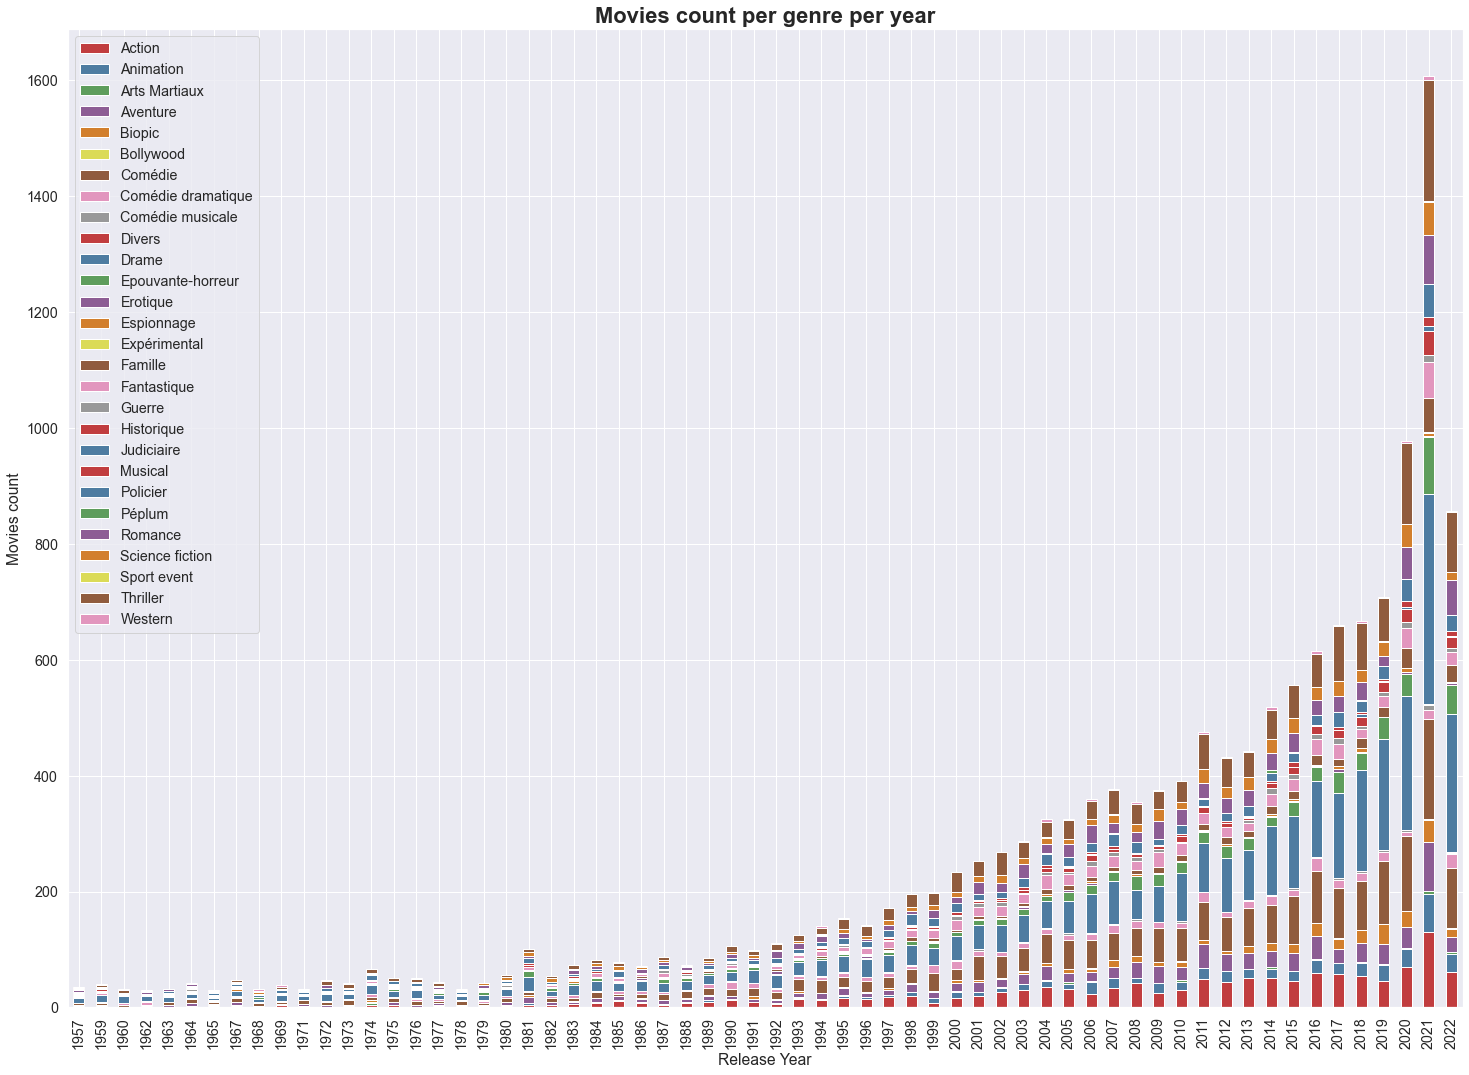

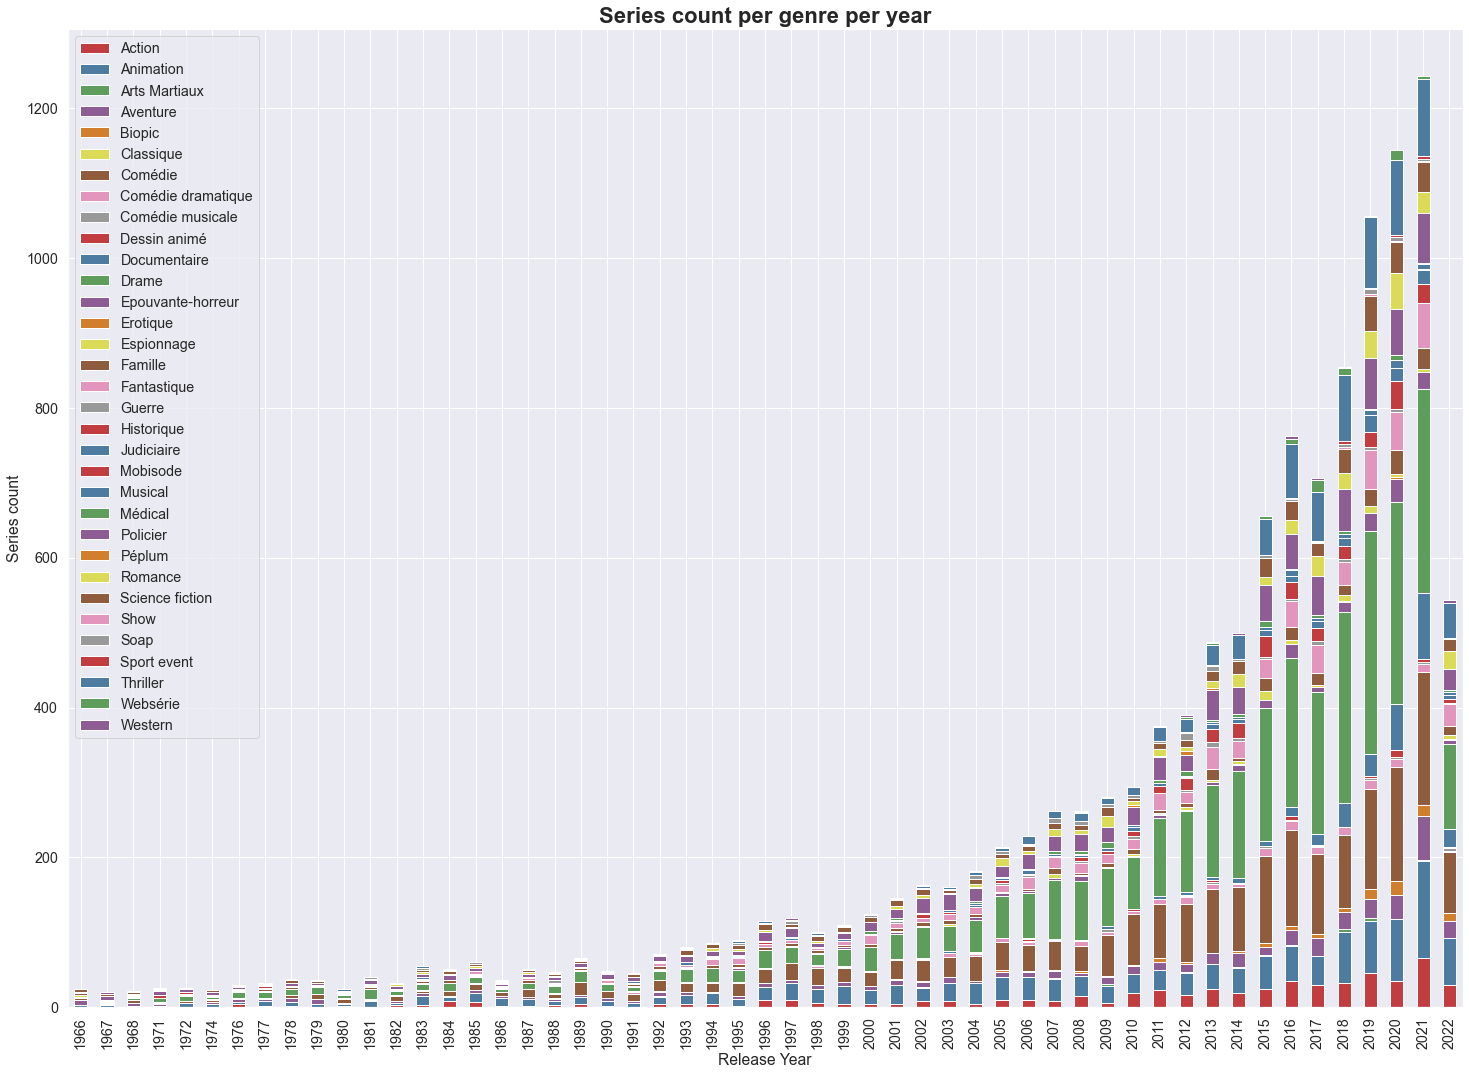

In [71]:
m_genres_year = genres_per_year("movies", display=True)
s_genres_year = genres_per_year("series", display=True)

## Genre correlation plot

In [72]:
def genre_correlation(key: str, param: str):
    '''
    Plot the correlation between the genres and the param.
    :param key: The data_cleaned key to get the genre from.
    :param param: The parameter to get the correlation from.
    :return: Save the plot of the correlation between the genres and the param.
    '''
    try:
        if param == "year":
            if key == "movies":
                genres_matrix = m_genres_year
            elif key == "series":
                genres_matrix = s_genres_year
            genres_matrix["release_year"] = genres_matrix.index
            genres_matrix.reset_index(drop=True, inplace=True)

            # Plot the correlation Heatmap
            plt.figure()
            # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
            # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
            sns.heatmap(genres_matrix.corr(), vmin=-1, vmax=1, annot=True, cmap="gist_heat", annot_kws={"size": 10, "weight": "bold"})
            # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
            plt.title(f"Heatmap of correlation between {key.title()} genres and users ratings", fontsize=20, fontweight="bold", pad=12) 
            fig = plt.gcf()
            plt.show()
            # Save the figures
            fig.savefig(f"{key}_genre_{param}_corr.png", bbox_inches='tight', dpi='figure')
    except Exception as e:
        print(f"Error in genre_correlation:\n {e}")

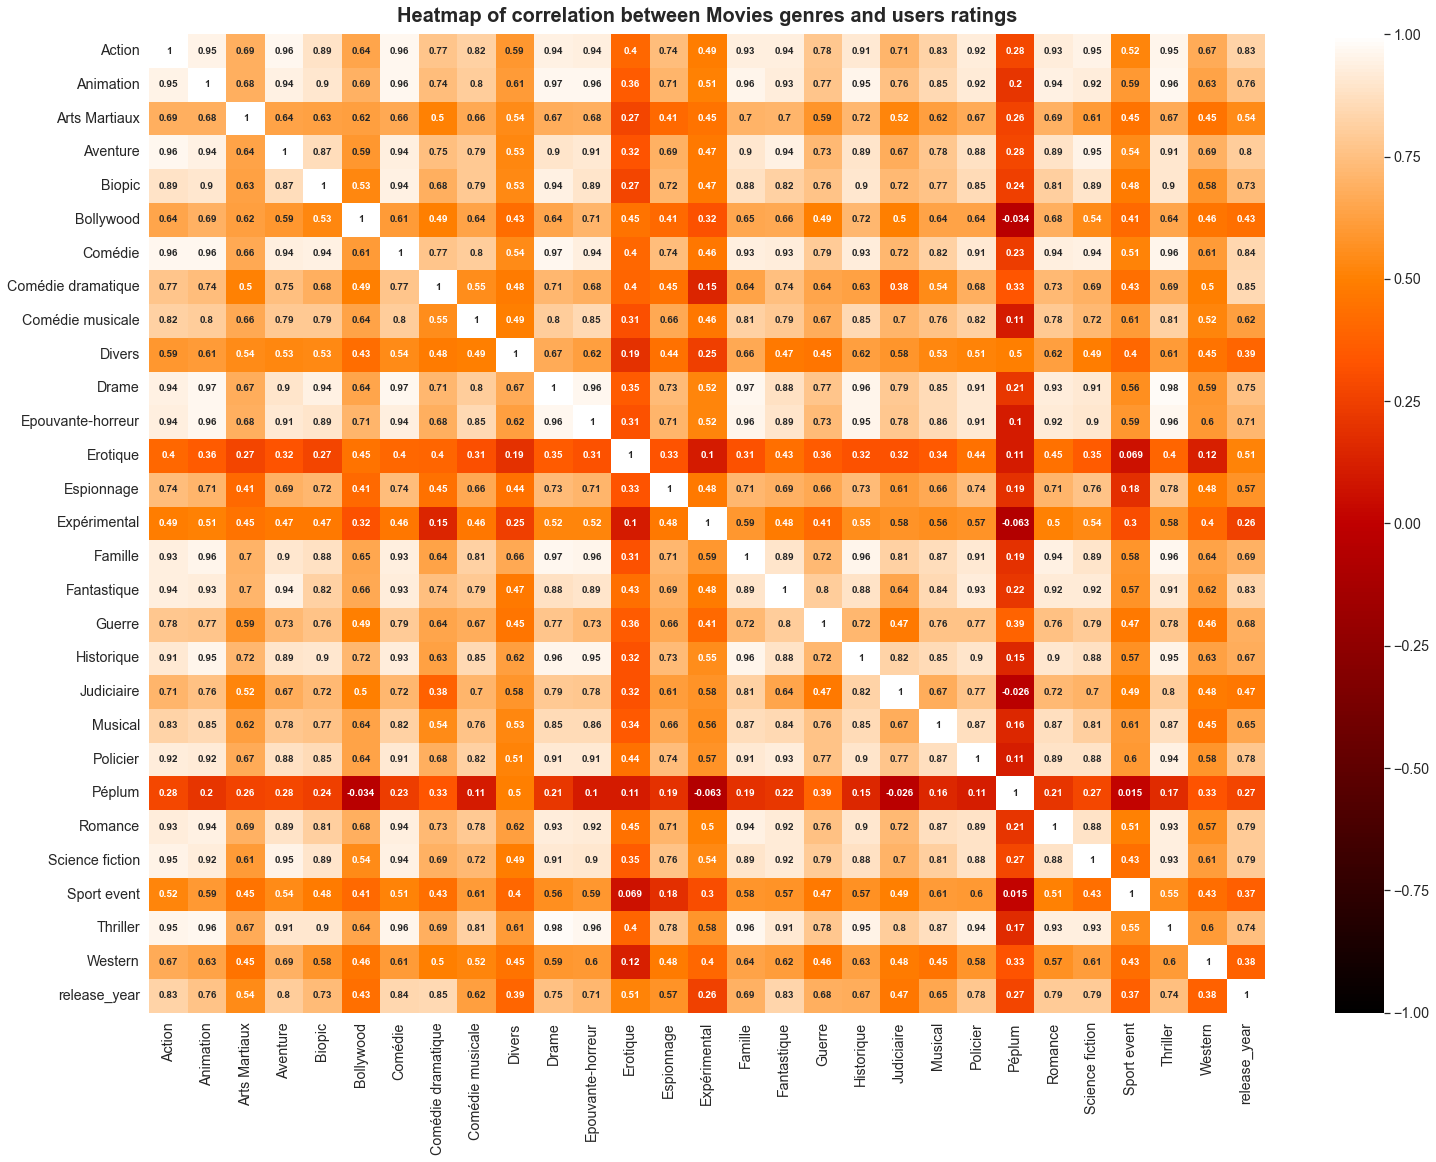

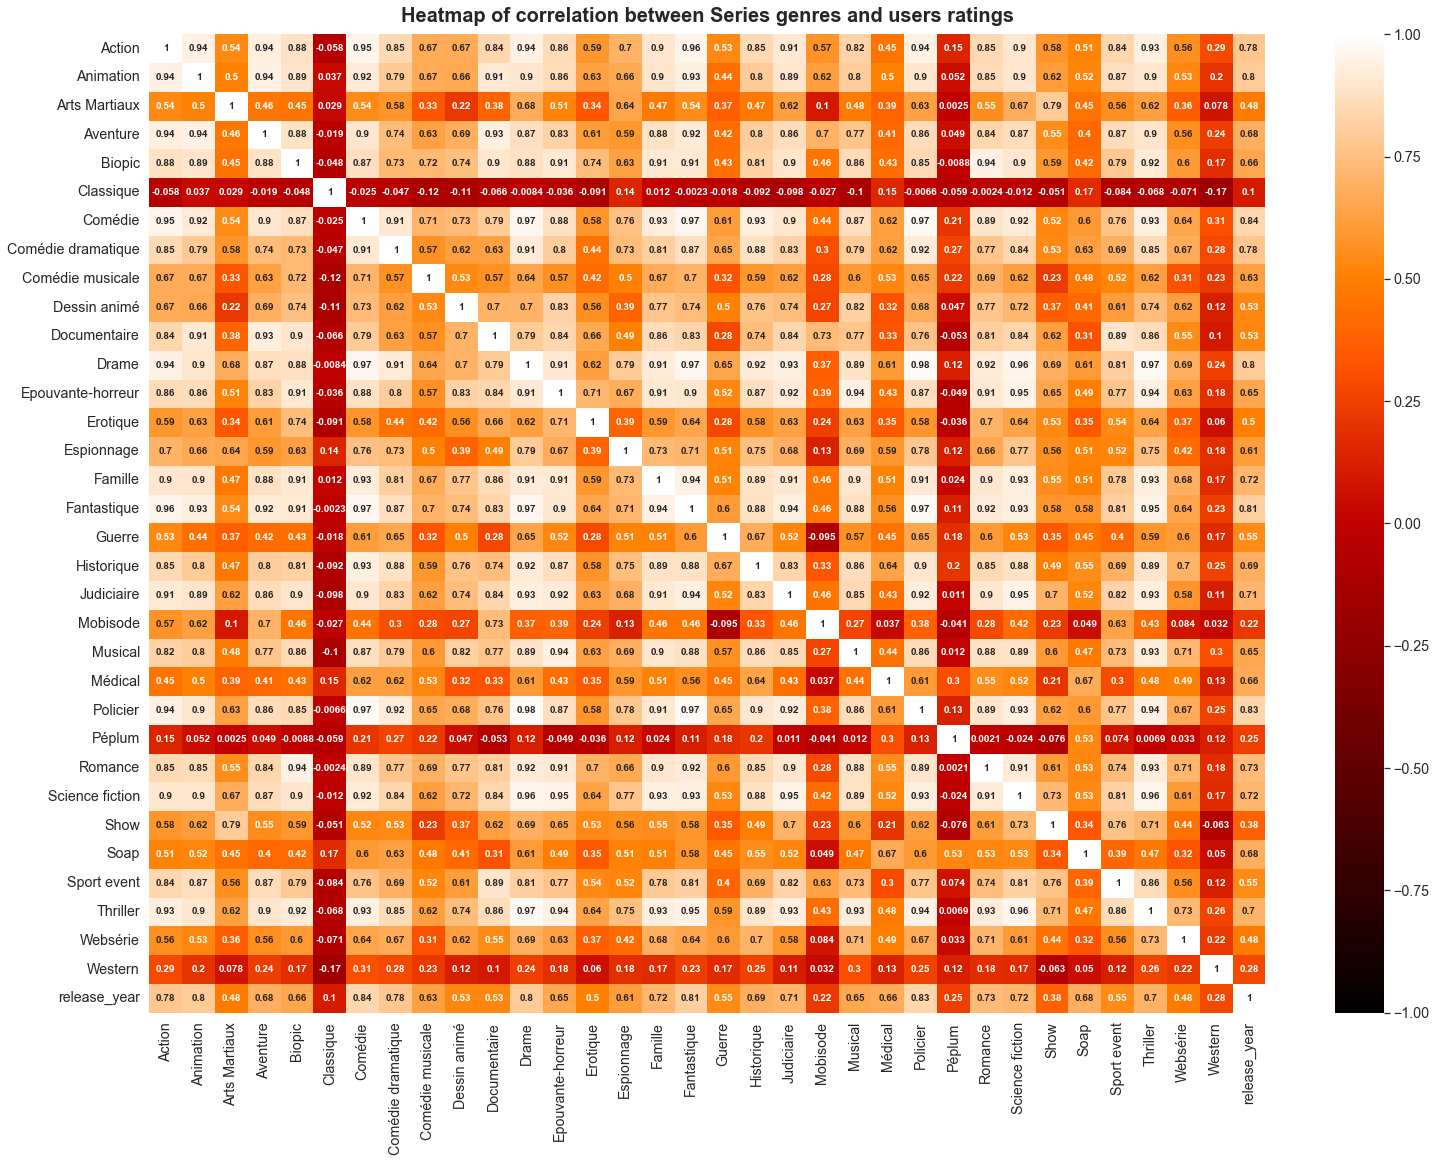

In [73]:
genre_correlation(key="movies", param="year")
genre_correlation(key="series", param="year")

In [74]:
# Add the genres to the user ratings dataframe
# user_m_ratings_genres = user_movies.merge(m_clean[["id","genres"]], left_on="movie_id", right_on="id",how="left")
# user_s_ratings_genres = user_series.merge(s_clean[["id","genres"]], left_on="series_id", right_on="id")

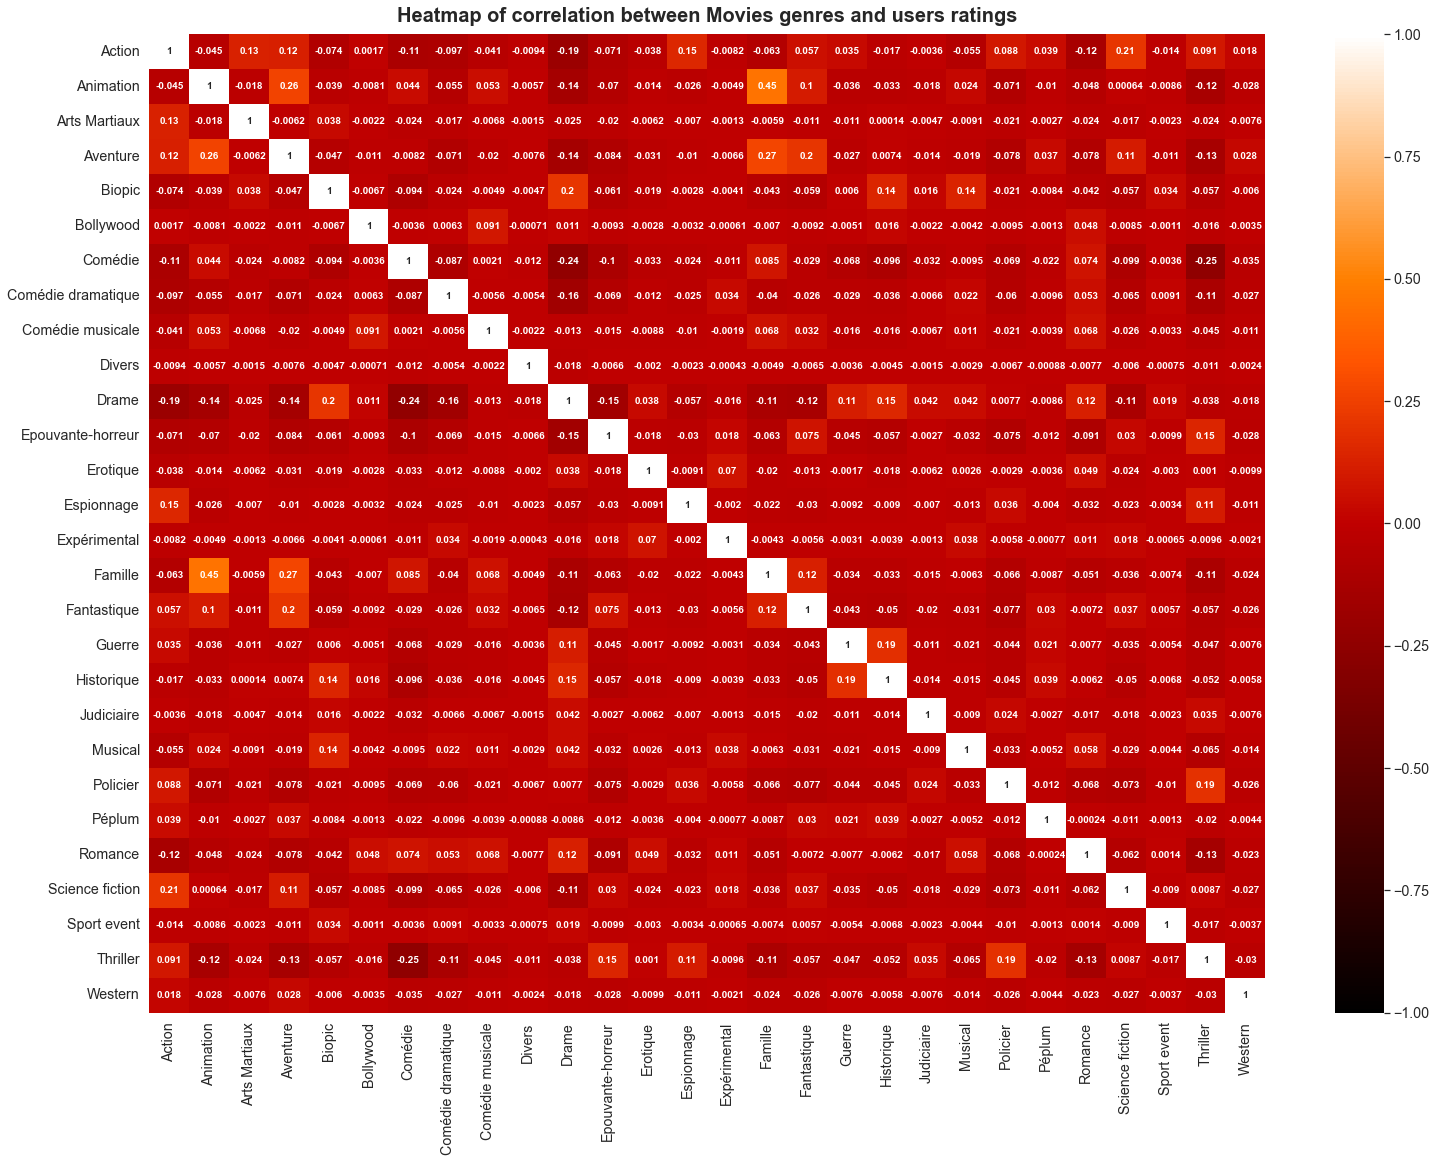

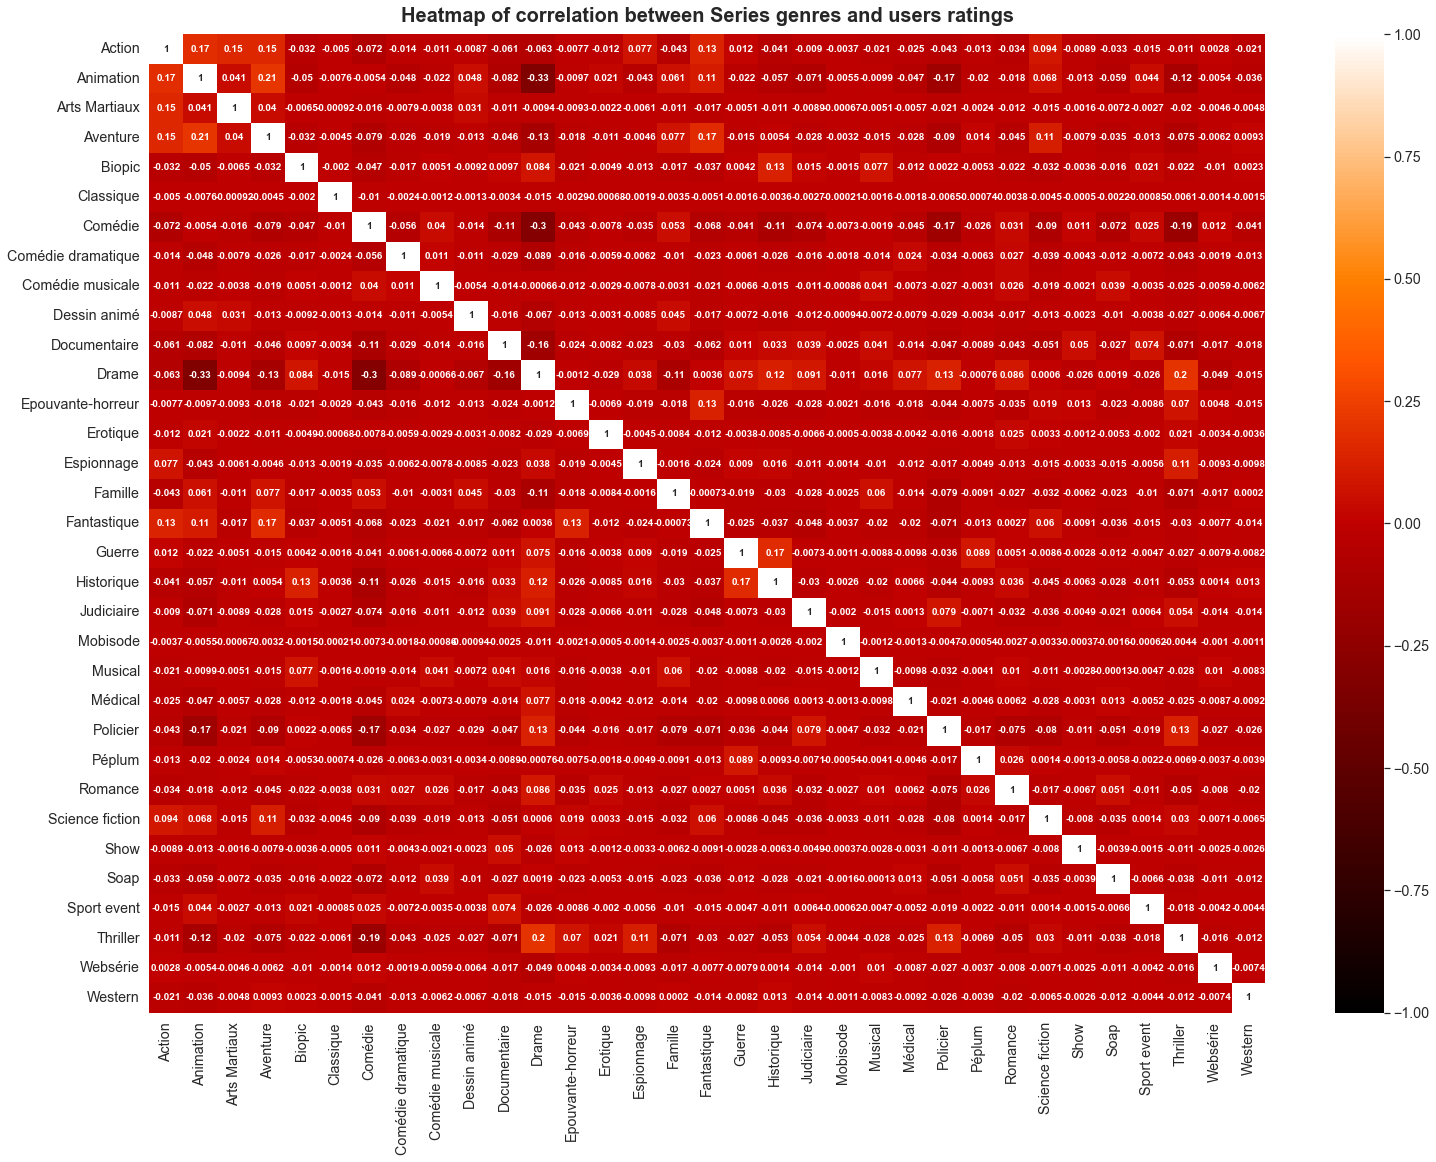

In [75]:
for k,df in list(data_cleaned.items())[:2]:
    # Create a matrix of the average rating per genre
    genres_ratings_matrix = df.copy()[["id", "user_rating", "genres"]]
    genres_ratings_matrix.dropna(inplace=True)
    genres_ratings_matrix.reset_index(drop=True, inplace=True)
    if k == "movies":
        genres_ratings_matrix[m_genres_df.genres.values.tolist()] = 0
    elif k == "series":
        genres_ratings_matrix[s_genres_df.genres.values.tolist()] = 0
        
    for index, row in genres_ratings_matrix.iterrows():    
        genres_ratings_matrix.at[index,row["genres"]] = 1*row["user_rating"]

    # Plot the correlation Heatmap
    plt.figure()
    # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
    # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
    sns.heatmap(genres_ratings_matrix[genres_ratings_matrix.columns[3:]].corr(), vmin=-1, vmax=1, annot=True, cmap="gist_heat", annot_kws={"size": 10, "weight": "bold"})
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    plt.title(f"Heatmap of correlation between {k.title()} genres and users ratings", fontsize=20, fontweight="bold", pad=12) 
    fig = plt.gcf()
    plt.show()
    # save the fig
    fig.savefig(f"{k}_genre_user_corr.png", bbox_inches='tight', dpi='figure')